Propagating Light
==============


This notebook shows examples of using `aotools` to do the following:
- Propagate a complex wave physically
- Include scintillation effects in simulations (twinkling!)

In [248]:
import numpy
import matplotlib.pylab as plt
from tqdm import tqdm, trange, tqdm_notebook
from astropy.io import fits
%matplotlib inline
import aotools
from aotools.turbulence import infinitephasescreen, phasescreen
from matplotlib import animation, rcParams
rcParams['figure.figsize'] = [10,5]
from IPython.display import HTML
import matplotlib.colors as colors
j = 0+1j

In [250]:
# Set up parameters for creating phase screens
nx_size = 64 # pxls
D = 0.05 # m
pxl_scale = 1/64 # m/pxl
pad_factor = 2
r0 = 0.16 # m
L0 = 50 # m
l0 = 1e-3 # m
wavelength = 500e-9 # m

# Create the phase screen object using aotools
phase_screen = infinitephasescreen.PhaseScreenKolmogorov(nx_size * pad_factor, pxl_scale, r0, L0)

Physical Optics Propagation
--------------

Up to this point we have assumed the "near field" approximation, that our phase aberration (phase screens) are at, or close to, the pupil of our imaging system. This holds in many applications including most of astronomy. However, to fully describe the propagation of light through a turbulent atmosphere to our imaging system, we must take into account propagation of light and its effect on the phase and amplitude. `aotools` contains several routines for propagation of light, and here we will consider the `angularSpectrum` method.

First, we create our complex field by doing $e^{i\phi}$ for our phase screen $\phi$.

In [226]:
complex_field = numpy.exp(j*phase_screen.scrn) # Convert the wavefront to a complex amplitude

Text(0.5, 1.0, 'phase')

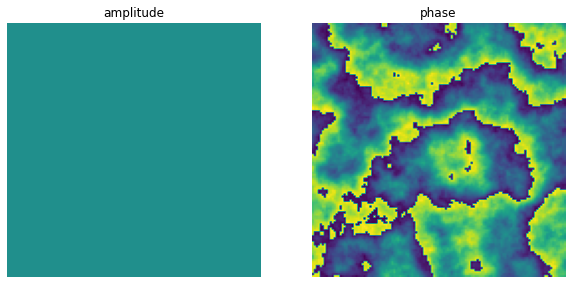

In [227]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(numpy.abs(complex_field), vmin=0.9, vmax=1.1)
plt.axis('off')
plt.title('amplitude')
plt.subplot(1,2,2)
plt.imshow(numpy.angle(complex_field), vmin=-numpy.pi, vmax=numpy.pi)
plt.axis('off')
plt.title('phase')

Now we propagate the field some distance with the `angularSpectrum` propagation method.

In [228]:
propagation_distance = 10000 # 10 km
propagated_field = aotools.opticalpropagation.angularSpectrum(complex_field, wavelength, pxl_scale, pxl_scale, propagation_distance)

Text(0.5, 1.0, 'phase')

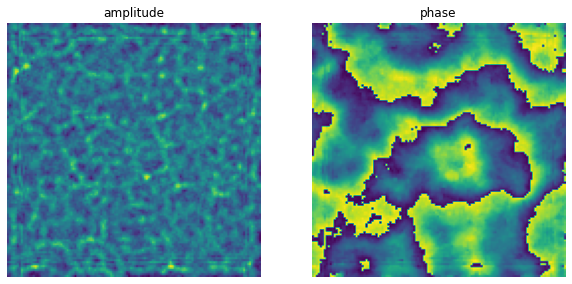

In [229]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(numpy.abs(propagated_field))
plt.axis('off')
plt.title('amplitude')
plt.subplot(1,2,2)
plt.imshow(numpy.angle(propagated_field))
plt.axis('off')
plt.title('phase')

We can see the amplitude becomes non-uniform, and the phase is almost unchanged. Around the edges, some artifacts have appeared. These are diffraction rings caused by the hard edges of our simulation domain. Again, it is therefore important to ensure that the simulation domain is oversized compared to the entrance pupil of the imaging system.

Scintillation 
=

This amplitude fluctuation, when integrated over an aperture, causes scintillation or twinkling of stars. The intensity pattern is simply the modulus square of the complex field at the aperture

In [230]:
I = numpy.abs(propagated_field)**2 # Scintillation intensity patterns

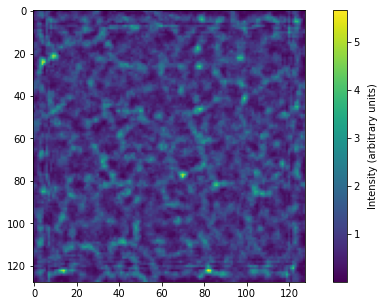

In [231]:
plt.figure()
plt.imshow(I)
cbar = plt.colorbar()
cbar.set_label('Intensity (arbitrary units)', labelpad=8)

We can see how this pattern changes as we increase the altitude of the phase aberration 

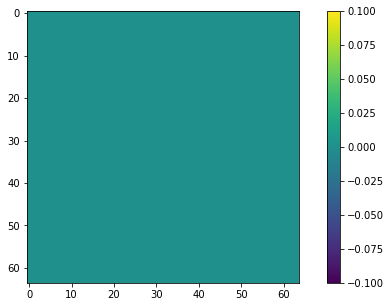

In [223]:
# Video of moving a phase screen
fig, ax = plt.subplots()
image = ax.imshow(numpy.zeros((64, 64)))
fig.colorbar(image)

def init():
    image.set_data(numpy.zeros((64, 64)))
    return (image,)

def animate(i):
    propagation_distance=i*250
    propagated_wavefront = aotools.opticalpropagation.angularSpectrum(complex_field, wavelength, pxl_scale, pxl_scale, propagation_distance)
    I = numpy.abs(propagated_wavefront)**2
    image.set_data(I)
    image.autoscale()
    ax.set_title("Propagation distance = %.1f km" % (propagation_distance/1000.))
    return (image,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, 
                               blit=True)

In [224]:
HTML(anim.to_html5_video())

We can now use our previous knowledge to generate a PSF including scintillation

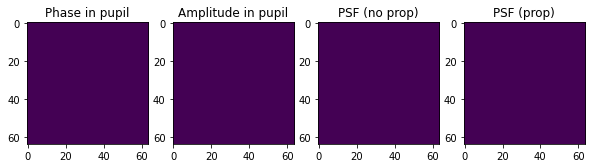

In [244]:
frames=500

pupil = aotools.circle(D/pxl_scale/2, nx_size)
pad_size = nx_size * pad_factor
phase_screen = infinitephasescreen.PhaseScreenKolmogorov(pad_size, pxl_scale, r0, L0)
padded_pupil = numpy.zeros((nx_size*pad_factor, nx_size*pad_factor), dtype=numpy.complex64)
padded_pupil_prop = padded_pupil.copy()
padded_field = numpy.zeros((pad_size, pad_size), dtype=numpy.complex64)
psfs = numpy.zeros((frames, nx_size*pad_factor, nx_size*pad_factor))
cut_start = pad_size//2 - nx_size//2
cut_end = pad_size//2 + nx_size//2

# Video of moving a phase screen and PSF
fig, [ax1, ax2, ax3, ax4] = plt.subplots(nrows=1, ncols=4)
screen_image = ax1.imshow(numpy.zeros((nx_size, nx_size)))
intensity_image = ax2.imshow(numpy.zeros((nx_size, nx_size)))
psf_image = ax3.imshow(numpy.zeros((nx_size, nx_size)))
prop_psf_image = ax4.imshow(numpy.zeros((nx_size, nx_size)))
ax1.set_title("Phase in pupil")
ax2.set_title("Amplitude in pupil")
ax3.set_title("PSF (no prop)")
ax4.set_title("PSF (prop)")

def init():
    screen_image.set_data(numpy.zeros((nx_size, nx_size)))
    intensity_image.set_data(numpy.zeros((nx_size, nx_size)))
    psf_image.set_data(numpy.zeros((nx_size, nx_size)))
    prop_psf_image.set_data(numpy.zeros((nx_size, nx_size)))
    return (screen_image, psf_image, prop_psf_image,)

def animate(i):  
    phase_screen.add_row()
    wavefront = numpy.copy(phase_screen.scrn)
    screen_image.set_data(wavefront[cut_start:cut_end,cut_start:cut_end]*pupil)
    screen_image.autoscale()
    
    padded_field[:,:] = numpy.exp(j * wavefront)
    padded_pupil[cut_start:cut_end,cut_start:cut_end] = padded_field[cut_start:cut_end, cut_start:cut_end] * pupil
    
    # Use AOtools to transform from the pupil to the focal plane
    psf = numpy.abs(aotools.ft2(padded_pupil, delta=pxl_scale))**2.
    
    psf_cut = psf[cut_start:cut_end,cut_start:cut_end]
    
    psf_image.set_data(psf_cut)
    psf_image.autoscale()
    
    prop_field = aotools.opticalpropagation.angularSpectrum(padded_field, wavelength, pxl_scale, pxl_scale, propagation_distance)
    padded_pupil_prop[cut_start:cut_end,cut_start:cut_end] = prop_field[cut_start:cut_end, cut_start:cut_end] * pupil
    
    intensity_image.set_data(numpy.abs(padded_pupil_prop[cut_start:cut_end,cut_start:cut_end])**2)
    intensity_image.autoscale()
    
    psf_prop = numpy.abs(aotools.ft2(padded_pupil_prop, delta=pxl_scale))**2
    psf_prop_cut = psf_prop[cut_start:cut_end,cut_start:cut_end]
    
    prop_psf_image.set_data(psf_prop_cut)
    prop_psf_image.set_clim(psf_image.get_clim())
    
    return (screen_image, intensity_image, psf_image, prop_psf_image)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frames, interval=10, 
                               blit=True)

In [245]:
HTML(anim.to_html5_video())

Scintillation Statistics
-------------------------

We can also explore the statistics of these scintillation patterns. To do these we will need to create a large sample of phase screens and measure statistical properties of the set of phase screens. This is similar to the previous analysis to calculate the Zernike power spectrum of the phase of the phase screens.

In order to calculate the power spectrum of the scintillation patterns we can use a fourier transform, as the power spectrum is defined as the modulus square of the fourier transform. Note that the spatial power spectrum, while a very similar computation to the PSF, does not have an aperture function applied.

In [324]:
# Generate a large set of phase screens
N_scrns = 1000
propagation_distance = 10000

phase_screens = numpy.zeros((N_scrns, pad_size, pad_size))
Is = numpy.zeros_like(phase_screens)
powerspec = numpy.zeros_like(phase_screens)
for i in tqdm(range(N_scrns)):
    phase_screens[i] = phasescreen.ft_phase_screen(r0, pad_size, pxl_scale, L0, l0)
    Is[i] = numpy.abs(aotools.opticalpropagation.angularSpectrum(numpy.exp(j*phase_screens[i]), 500e-9, pxl_scale, pxl_scale, propagation_distance))**2
    powerspec[i] = abs(aotools.fouriertransform.ft2(Is[i], pxl_scale))**2

100%|██████████| 1000/1000 [00:02<00:00, 462.90it/s]


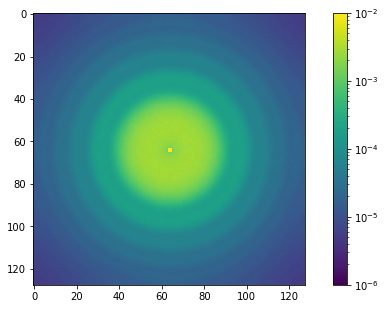

In [325]:
# Plot 2d irradiance power spectrum
plt.figure()
plt.imshow(powerspec.mean(0), norm=colors.LogNorm(1e-6,1e-2))
cbar = plt.colorbar()

The power spectrum is circularly symmetric, so we can take an azimuthal average as for the PSFs

In [326]:
# Take azimuthal avg of 2d spatial power spectrum to compare with theory
powerspec_1d = aotools.azimuthal_average(powerspec.mean(0))

In [327]:
spatial_freqs = numpy.fft.fftshift(numpy.fft.fftfreq(pad_size, d=pxl_scale))[pad_size//2+1:] # Fourier space coordinates

In [328]:
# Theoretical power spectrum
def W(f, z, cn2, wvl=500e-9):
    '''
    Spatial power spectrum of irradiance fluctuations (see Tokovinin 2002 for more detail)

    Assumes Kolmogorov turbulence and weak perturbation limit.
    '''
    return 3.9e-2 * (2*numpy.pi/wvl)**2 * cn2 * f**(-11/3) * (numpy.sin(numpy.pi * wvl * z * f**2))**2

W_th = W(spatial_freqs, propagation_distance, aotools.r0_to_cn2(r0))

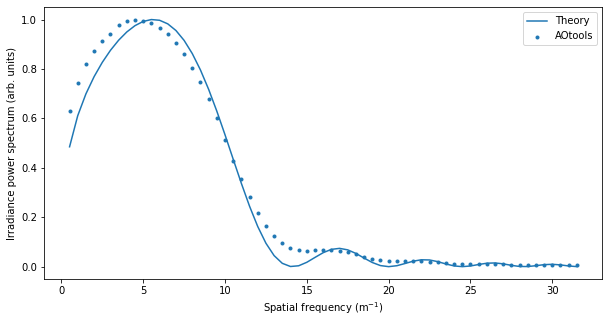

In [329]:
plt.figure()
plt.plot(spatial_freqs, W_th/W_th.max(), label='Theory')
plt.scatter(spatial_scales, powerspec_1d[1:]/powerspec_1d[1:].max(), marker='.', label='AOtools')
plt.xlabel('Spatial frequency (m$^{-1}$)')
plt.ylabel('Irradiance power spectrum (arb. units)')
plt.legend(loc=0)
# plt.xlim(0,30)